In [1]:
import random

import matplotlib as mpl
import numpy as np
import torch
import torch.utils.data

import theseus as th
import theseus.utils.examples as theg

%load_ext autoreload
%autoreload 2

torch.set_default_dtype(torch.double)

device = "cuda:0" if torch.cuda.is_available else "cpu"
seed = 0
torch.random.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["font.size"] = 16

In [4]:
!pwd

/home/peteryu/SEANRobotGuide/demo


In [22]:
dataset_dir = "/home/peteryu/SEANRobotGuide/data/motion-planning-2d/dataset"
train_dataset = theg.TrajectoryDataset(True, 1000, dataset_dir, map_type="tarpit", filter_collision_maps=False)
train_dl = torch.utils.data.DataLoader(train_dataset)

# test_dataset = theg.TrajectoryDataset(False, 1000, dataset_dir, val_ratio=0.3, map_type="tarpit", )
# test_dl = torch.utils.data.DataLoader(test_dataset)

print(len(train_dl))

batch = next(iter(train_dl))
for k, v in batch.items():
    if k != "file_id":
        print(f"{k:20s}: {v.shape}")
    else:
        print(f"{k:20s}: {v}")

1000
map_tensor          : torch.Size([1, 128, 128])
sdf_origin          : torch.Size([1, 2])
cell_size           : torch.Size([1, 1])
sdf_data            : torch.Size([1, 128, 128])
expert_trajectory   : torch.Size([1, 4, 101])
file_id             : ['tarpit_741']


/tmp/ipykernel_279662/3644489733.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[0].show()


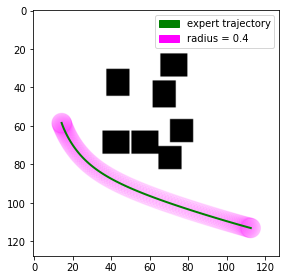

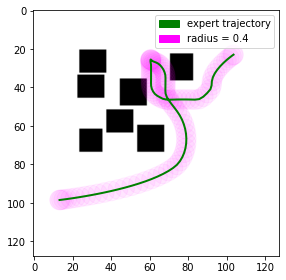

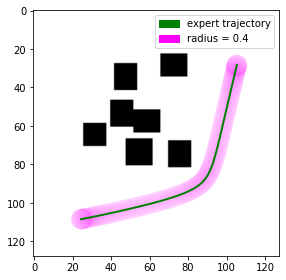

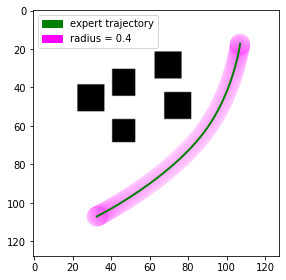

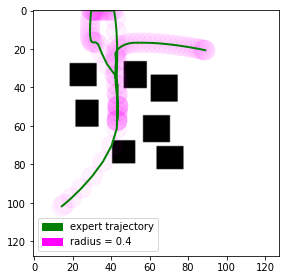

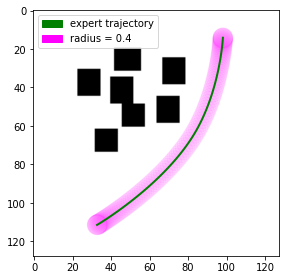

In [41]:
sdf = th.eb.SignedDistanceField2D(
    th.Point2(batch["sdf_origin"]),
    th.Variable(batch["cell_size"]),
    th.Variable(batch["sdf_data"]),
)

i = 0
for trial in train_dl:
    
    sdf = th.eb.SignedDistanceField2D(
        th.Point2(trial["sdf_origin"]),
        th.Variable(trial["cell_size"]),
        th.Variable(trial["sdf_data"]),
    )
    
    figs = theg.generate_trajectory_figs(
        trial["map_tensor"], 
        sdf, 
        [trial["expert_trajectory"]],
        robot_radius=0.4, 
        labels=["expert trajectory"], 
        fig_idx_robot=0,
        figsize=(10, 4),
    )
    
    figs[0].show()
    
    if i == 5:
        break
    i+=1

In [32]:
# Constant for optimization
# trajectory_len = batch["expert_trajectory"].shape[2]
# num_time_steps = trajectory_len - 1
# map_size = batch["map_tensor"].shape[1]
safety_distance = 0.4
robot_radius = 0.4
total_time = 10.0
# dt_val = total_time / num_time_steps
Qc_inv = [[1.0, 0.0], [0.0, 1.0]]
collision_w = 20.0
boundary_w = 100.0

In [33]:
batch['sdf_data']

tensor([[[3.8313, 3.7711, 3.7116,  ..., 4.0179, 4.0880, 4.1583],
         [3.7824, 3.7214, 3.6611,  ..., 3.9836, 4.0542, 4.1251],
         [3.7345, 3.6727, 3.6115,  ..., 3.9505, 4.0217, 4.0932],
         ...,
         [4.8770, 4.8324, 4.7886,  ..., 5.0931, 5.1521, 5.2116],
         [4.9411, 4.8970, 4.8538,  ..., 5.1450, 5.2034, 5.2623],
         [5.0055, 4.9620, 4.9194,  ..., 5.1975, 5.2553, 5.3136]]])

In [35]:
torch.count_nonzero(torch.ones((1,128,128)) - batch['map_tensor'])

tensor(1128)

In [40]:
i = 0
for trial in train_dl:
    for k, v in trial.items():
        if k == "cell_size" or k == "sdf_origin" or k == "file_id":
            print(f"{k:20s}: {v}")
        else: 
            print(f"{k:20s}: {v.shape}")
    print("---------------------")
    if i == 3:
        break
    i+=1

map_tensor          : torch.Size([1, 128, 128])
sdf_origin          : tensor([[-5., -5.]])
cell_size           : tensor([[0.0781]])
sdf_data            : torch.Size([1, 128, 128])
expert_trajectory   : torch.Size([1, 4, 101])
file_id             : ['tarpit_741']
---------------------
map_tensor          : torch.Size([1, 128, 128])
sdf_origin          : tensor([[-5., -5.]])
cell_size           : tensor([[0.0781]])
sdf_data            : torch.Size([1, 128, 128])
expert_trajectory   : torch.Size([1, 4, 101])
file_id             : ['tarpit_407']
---------------------
map_tensor          : torch.Size([1, 128, 128])
sdf_origin          : tensor([[-5., -5.]])
cell_size           : tensor([[0.0781]])
sdf_data            : torch.Size([1, 128, 128])
expert_trajectory   : torch.Size([1, 4, 101])
file_id             : ['tarpit_955']
---------------------
map_tensor          : torch.Size([1, 128, 128])
sdf_origin          : tensor([[-5., -5.]])
cell_size           : tensor([[0.0781]])
sdf_data     

In [43]:
# Check if every trial as the same number of time steps
trial_count = 0
broken_count = 0
for trial in train_dl:
    if trial["expert_trajectory"].size() != (1, 4, 101):
        broken_count += 1
    trial_count += 1

print(trial_count, broken_count)

1000 0


In [107]:
# Get start and goal

example_trial = next(iter(train_dl))
ex_map_tensor = example_trial["map_tensor"]
ex_sdf_data = example_trial["sdf_data"]
ex_expert_traj = example_trial["expert_trajectory"]

start = torch.transpose(ex_expert_traj.squeeze(), 0, 1)[0]
goal = torch.transpose(ex_expert_traj.squeeze(), 0, 1)[-1]
start_and_goal = torch.tensor([[start[0], start[1], goal[0], goal[1]]])
print(start_and_goal, start_and_goal.size())

input_data = torch.cat((ex_map_tensor, ex_sdf_data), 0).expand((1,2,128,128))
print(input_data.size())

tensor([[-3.8836, -0.4344,  3.7963,  3.8337]]) torch.Size([1, 4])
torch.Size([1, 2, 128, 128])


In [120]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_dim=2, output_dim=101*2):
        super().__init__()
        
        self.without_start_goal = nn.Sequential(
            nn.Conv2d(input_dim, 64, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.AvgPool2d(kernel_size=3, stride=3),
            
            nn.Conv2d(64, 32, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.AvgPool2d(kernel_size=3, stride=3),
        )
        
        self.with_start_goal = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.AvgPool2d(kernel_size=3, stride=3),
            
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.AvgPool2d(kernel_size=3, stride=3),
        )
        
        self.fc1 = nn.Linear(2016, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x, start_and_goal):
        output = self.without_start_goal(x)
        print(output.size())
        output = output.reshape(1, -1)
        output = torch.cat((output, start_and_goal), 1)
        print(output.size()) # => 5412
        output = output.reshape(1, 1, 66, -1)        
        output = self.with_start_goal(output)
        output = torch.flatten(output, 1)
        return self.fc2(self.fc1(output))
    

In [121]:
net = CNN(input_dim=2, output_dim=202)
out = net(input_data, start_and_goal)
print(out.size())

torch.Size([1, 32, 13, 13])
torch.Size([1, 5412])
torch.Size([1, 202])
